In [24]:
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema


from fink_utils.sso import spins as finkus
import ssptools

In [25]:
# import sys
# sys.path.append('/home/bcarry/Documents/softs/ocapy/gfx/')
# import figure_setup as fs

In [26]:
# To test new ssocards
# rocks.ssodnet.URL_SSODNET = 

# Get ZTF fit

In [27]:
# Local Configuration
bft_file = '/data/ssodnet/ssoBFT-latest.parquet'
data_fink = '/data/fink/tutorials/sso/spins/'
data_fink = './'

# To choose the definition of sets
# gold_silver_choice = 'julien'
gold_silver_choice = 'benoit'

In [28]:
# Threshold for selection (of non-zero values)
thres = 1e-3

# Minimum phase angle to consider
min_phase = 3

In [29]:
# ZTF filters 1: g, 2: r
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])


In [30]:
data = pd.read_parquet(f'{data_fink}data/sso_bft_50_inf_allsolutions.parquet')

In [31]:
data['HG1G2hyb_dSpin'] = np.sqrt( (data['HG1G2hyb_dRA0']*np.cos(np.radians(data['HG1G2hyb_DEC0'])))**2 + data['HG1G2hyb_dDEC0']**2 )


# Remove solutions above 90 deg of latitude
cond = data.HG1G2hyb_DEC0 > 90
data.loc[cond,'HG1G2hyb_DEC0'] = 90
cond = data.HG1G2hyb_DEC0 < -90
data.loc[cond,'HG1G2hyb_DEC0'] = -90

# Spin coordinates: long/lat
# Define angle for astropy
ra = data.HG1G2hyb_RA0*u.degree
dec = data.HG1G2hyb_DEC0*u.degree

# Convert to EC and store in the pandas DataFrame
coords = SkyCoord(ra=ra, dec=dec, distance=200*u.parsec, frame='hcrs')
data['lon'] = coords.heliocentricmeanecliptic.lon.value
data['lat'] = coords.heliocentricmeanecliptic.lat.value



In [32]:
bft = pd.read_parquet(bft_file)

In [33]:
cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3.RA0.value', 'spins.3.DEC0.value',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ]        

In [34]:
data = data.merge( bft[cols], left_on='name', right_on='sso_name', how='left' )

In [35]:
data

,ssnamenr,number,name,minphase,maxphase,n_days,n_obs,HG_H,HG_dH,HG_G,...,spins.3.DEC0.value,spins.3.long.value,spins.3.lat.value,spins.3.technique,spins.4.obliquity,spins.4.RA0.value,spins.4.DEC0.value,spins.4.long.value,spins.4.lat.value,spins.4.technique
0,3378,3378,Susanvictoria,7.209902,27.973639,694.757685,163,13.835591,0.073765,0.186857,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
1,66214,66214,1999 CO36,2.763971,24.397613,972.951458,73,15.128266,0.062540,0.027824,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
2,30141,30141,Nelvenzon,3.434811,23.955449,621.800359,53,16.165762,0.136274,0.613963,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
3,161891,161891,2007 DW10,1.758005,21.985170,632.723530,61,15.447201,0.046601,0.117947,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
4,85970,85970,Fundacaoterra,0.822790,22.376936,998.833889,54,15.927574,0.101270,0.443576,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104160,64758,64758,2001 XL163,1.497470,29.740566,608.827500,79,15.778768,0.072580,0.114509,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
104161,76784,76784,2000 KR71,1.830102,25.589995,990.106308,82,15.468660,0.065853,0.093753,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
104162,181960,181960,1999 UM24,1.875814,18.193628,973.847419,107,14.037718,0.076177,0.000482,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
104163,366616,366616,2003 NP4,26.050772,37.302272,242.663241,153,16.717611,0.113371,0.149370,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None


In [36]:


# G1G2 mask for HG1G2, HG1G2spin, and hybrid model
maskG1G2 = (data.HG1G2_G1>thres)  & (data.HG1G2_G2>thres) & (1-data.HG1G2_G1-data.HG1G2_G2>thres)
maskG1G2sp = (data.HG1G2sp_G1>thres)  & (data.HG1G2sp_G2>thres) & (1-data.HG1G2sp_G1-data.HG1G2sp_G2>thres)
maskG1G2hyb_g = (data.HG1G2hyb_G1_g>thres)  & (data.HG1G2hyb_G2_g>thres) & (1-data.HG1G2hyb_G1_g-data.HG1G2hyb_G2_g>thres)
maskG1G2hyb_r = (data.HG1G2hyb_G1_r>thres)  & (data.HG1G2hyb_G2_r>thres) & (1-data.HG1G2hyb_G1_r-data.HG1G2hyb_G2_r>thres)
maskG1G2hyb = maskG1G2hyb_g * maskG1G2hyb_r

# G1G2 parameters likely to be wrong due to poor phase coverage
maskPhase = data.minphase<min_phase

# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (data.HG1G2hyb_RA0>thres) & ( np.abs(360-data.HG1G2hyb_RA0)>thres )  & \
           ( np.abs(data.HG1G2hyb_RA0-180)>thres) & ( np.abs(data.HG1G2hyb_DEC0)>thres ) 

# Mask on Fit status
maskFit = (data['HG1G2hyb_fit']==0) & ( (data['HG1G2hyb_status']==2) | (data['HG1G2hyb_status']==4) )

# General sample for tests
mask = maskG1G2 & maskG1G2sp & maskG1G2hyb & maskPhase & maskSpin

# Sample to be published
maskFINK = maskG1G2hyb & maskSpin & maskFit

print(' All data       :', len(data))
print('  Mask FINK     :', len(data[maskFINK]))
print('  Mask hyb      :', len(data[maskG1G2hyb]))
print('  Mask hyb g    :', len(data[maskG1G2hyb_g]))
print('  Mask hyb r    :', len(data[maskG1G2hyb_r]))
print('  Mask phase    :', len(data[maskPhase]))
print('  Mask Spin     :',len(data[maskSpin]))
print('  Mask          :', len(data[mask]))
print()
print('  Mask G1G2     :', len(data[maskG1G2]))
print('  Mask g1g2spin :', len(data[maskG1G2sp]))


 All data       : 104165
  Mask FINK     : 40582
  Mask hyb      : 47465
  Mask hyb g    : 60711
  Mask hyb r    : 64665
  Mask phase    : 68350
  Mask Spin     : 101714
  Mask          : 29818

  Mask G1G2     : 57063
  Mask g1g2spin : 66319


# Spin distribution

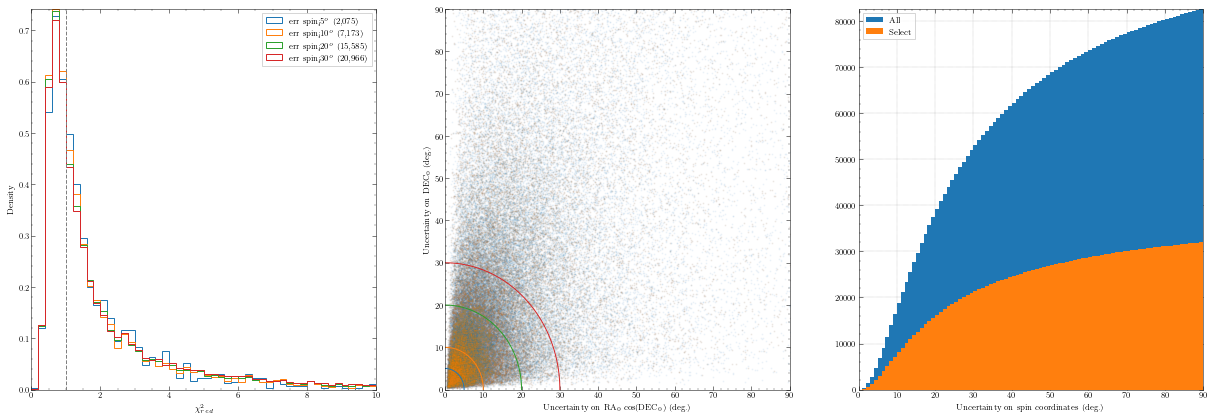

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))


# Histogram of chi2
for err in [5,10,20,30]:
    cond = maskFINK
    cond = cond*(data.HG1G2hyb_dSpin<=err)
    ax[0].hist(data.loc[cond,'HG1G2hyb_chi2red'], bins=50, histtype='step', density=True, range=[0,10],
               label=f'err spin<{err:d}$^o$ ({len(data[cond]):,d})')

    theta = np.linspace(0, np.pi/2, num=90 )
    ax[1].plot( err*np.cos(theta), err*np.sin(theta) )
    
ax[0].axvline(1, ls='--', color='grey')
ax[0].set_xlabel(r'$\chi^2_{red}$')
ax[0].set_ylabel('Density')
ax[0].legend()


# Scatter dRA dDEC
ax[1].scatter( data.HG1G2hyb_dRA0*np.cos(np.radians(data['HG1G2hyb_DEC0'])), data.HG1G2hyb_dDEC0, s=1, alpha=0.05 )
ax[1].scatter( data.loc[maskFINK,'HG1G2hyb_dRA0']*np.cos(np.radians(data.loc[maskFINK,'HG1G2hyb_DEC0'])), data.loc[maskFINK,'HG1G2hyb_dDEC0'], s=1, alpha=0.05 )
ax[1].set_xlim(0,90)
ax[1].set_ylim(0,90)

ax[1].set_xlabel('Uncertainty on RA$_0$ cos(DEC$_0$) (deg.)')
ax[1].set_ylabel('Uncertainty on DEC$_0$ (deg.)')

# Cumulative dSpin
r = [0,90]
b = 90
ax[2].hist( data.HG1G2hyb_dSpin, cumulative=True, density=False, range=r, bins=b, label='All' )
ax[2].hist( data.loc[maskFINK,'HG1G2hyb_dSpin'], cumulative=True, density=False, range=r, bins=b, label='Select' )

ax[2].grid()
ax[2].set_xlabel('Uncertainty on spin coordinates (deg.)')
ax[2].legend(loc='upper left')

# fig.savefig(f'{data_fink}plots/uncertainties_spin.png', facecolor='white', dpi=150)


Text(0, 0.5, 'DEC0 (deg)')

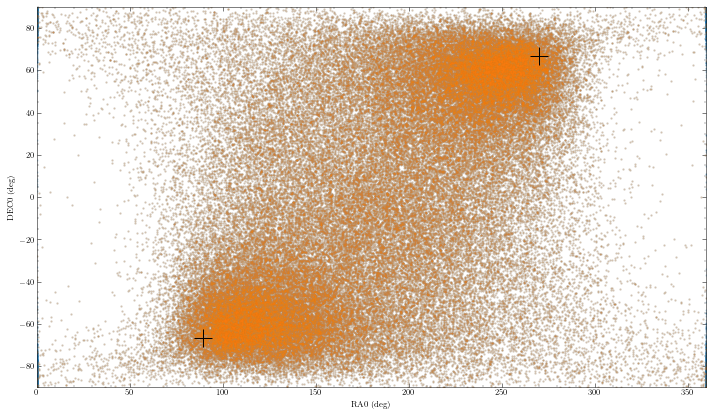

In [38]:
fig, ax = plt.subplots(figsize=(12, 7))

xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

cond = data.ssnamenr==data.ssnamenr
ax.scatter( data.loc[cond,xax], data.loc[cond,yax], s=2, alpha=0.15)

cond = maskSpin
ax.scatter( data.loc[cond,xax], data.loc[cond,yax], s=2, alpha=0.15)

coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
# fig.savefig(f'{data_fink}plots/ra0_vs_dec0_with_flip.png', facecolor='white', dpi=150)



- There are a few weird solution at RA0=0 or RA0=360 
- We need to flip RA/DEC of half the solution

Text(0.5, 0, 'DEC_0')

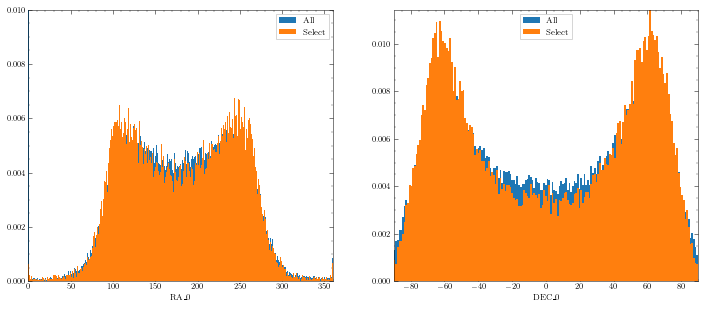

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].hist( data.HG1G2hyb_RA0, range=[0,360], bins=361, density=True, label='All' )
ax[0].hist( data.loc[maskFINK,'HG1G2hyb_RA0'], range=[0,360], bins=361, density=True, label='Select' )
ax[0].legend()
ax[0].set_xlabel('RA_0')

ax[1].hist( data.HG1G2hyb_DEC0, range=[-90,90], bins=181, density=True, label='All' )
ax[1].hist( data.loc[maskFINK,'HG1G2hyb_DEC0'], range=[-90,90], bins=181, density=True, label='Select' )
ax[1].legend()
ax[1].set_xlabel('DEC_0')

In [40]:
# Flip half of the solution
cond = (data.index %2 ==0 )
xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

data.loc[cond,xax] = (data.loc[cond,xax]+180) % 360
data.loc[cond,yax] = -data.loc[cond,yax]

# Convert (again) to EC
coords = SkyCoord(ra=data.loc[cond,xax]*u.deg, dec=data.loc[cond,yax]*u.deg, distance=200*u.parsec, frame='hcrs')
data.loc[cond,'lon'] = coords.heliocentricmeanecliptic.lon.value
data.loc[cond,'lat'] = coords.heliocentricmeanecliptic.lat.value

Text(0, 0.5, 'DEC0 (deg)')

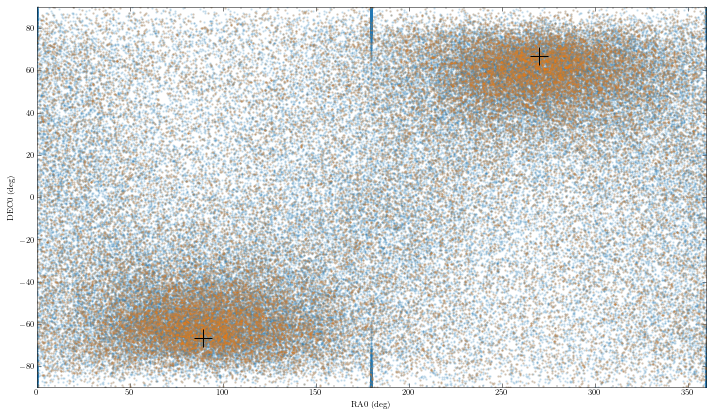

In [41]:
fig, ax = plt.subplots(figsize=(12, 7))

cond = data.ssnamenr==data.ssnamenr
xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

ax.scatter( data.loc[cond,xax], 
            data.loc[cond,yax], 
            s=2, alpha=0.15)

ax.scatter( data.loc[maskFINK,xax], 
            data.loc[maskFINK,yax], 
            s=2, alpha=0.15)

coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
# fig.savefig(f'{data_fink}plots/ra0_vs_dec0_with_flip.png', facecolor='white', dpi=150)



# Compare with literature

In [42]:
data['spins.1.technique'].value_counts()

LC        15872
LCI        2654
LC+TPM      568
TE           90
ADAM         42
LC-TPM       40
LC+Occ       16
Radar        16
SPACE         5
A-M           5
LC+IM         4
SAGE          4
Bin-IM        1
TE-Occ        1
Name: spins.1.technique, dtype: int64

In [43]:
# Compute angular distances
spin_version = np.array(['A','B'])

for ks in ['1','2','3','4']:
    data[f'spins.{ks}.distance'] = np.nan
    cond = (~data[f'spins.{ks}.RA0.value'].isna())
    
    #------------------------------------------------------------------------------------------
    # A: Original spins
    data.loc[cond,f'spins.{ks}.distance.A'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'HG1G2hyb_RA0','HG1G2hyb_DEC0']].apply(
        lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.A'] = (data.loc[cond,f'spins.{ks}.RA0.value']-data.loc[cond,'HG1G2hyb_RA0'] ) * np.cos(np.radians(data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.A'] = (data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'HG1G2hyb_DEC0'] )

    #------------------------------------------------------------------------------------------
    # B: RA-180 & Flip DEC
    data.loc[cond,f'spins.{ks}.distance.B'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'HG1G2hyb_RA0','HG1G2hyb_DEC0']].apply(
        lambda x: np.degrees(angular_separation( np.radians( (x[0]+180) % 360 ), np.radians(-x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.B'] = ( ((data.loc[cond,f'spins.{ks}.RA0.value']+180.0) % 360 )-data.loc[cond,'HG1G2hyb_RA0'] ) * np.cos(np.radians(-data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.B'] = (-data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'HG1G2hyb_DEC0'] )

    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.closest'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: int(np.argmin(x)), axis=1 )
    data = data.astype({f'spins.{ks}.closest':'Int64'})

    data.loc[cond,f'spins.{ks}.distance'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                            f'spins.{ks}.distance.B']].apply( lambda x: np.min(x), axis=1 )
    data.loc[cond,f'spins.{ks}.version'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: spin_version[np.argmin(x)], axis=1 )

    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.delta_RA'] = data.loc[cond, [f'spins.{ks}.delta_RA.A',
                                                            f'spins.{ks}.delta_RA.B', 
                                                            f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )
    data.loc[cond,f'spins.{ks}.delta_DEC'] = data.loc[cond, [f'spins.{ks}.delta_DEC.A',
                                                             f'spins.{ks}.delta_DEC.B', 
                                                             f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )

    
# Select the closest angularly
cond = ~data[f'spins.1.distance'].isna()
data.loc[cond,'spins.closest'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: int(np.argmin(x)), axis=1 )
data = data.astype({'spins.closest':'Int64'})

data.loc[cond,'spins.distance'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: np.min(x), axis=1 )
data.loc[cond,'spins.delta_RA'] = data.loc[cond, [f'spins.1.delta_RA',
                                                  f'spins.2.delta_RA',
                                                  f'spins.3.delta_RA',
                                                  f'spins.4.delta_RA', 
                                                  f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )
data.loc[cond,'spins.delta_DEC'] = data.loc[cond, [f'spins.1.delta_DEC',
                                                   f'spins.2.delta_DEC',
                                                   f'spins.3.delta_DEC',
                                                   f'spins.4.delta_DEC', 
                                                   f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )



(0.0, 90.0)

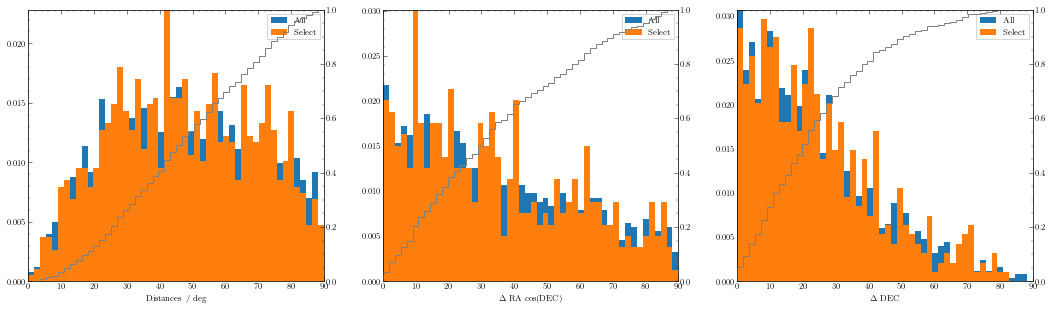

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

r = [0,90]
b = 50
ax[0].hist( data.loc[cond,'spins.distance'], range=r, bins=b, density=True, label='All' )
ax[0].hist( data.loc[maskFINK,'spins.distance'], range=r, bins=b, density=True, label='Select' )
ax[0].legend()
ax[0].set_xlabel('Distances / deg')
ax0 = ax[0].twinx()
ax0.hist( data.loc[maskFINK,'spins.distance'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='gray' )
ax[0].set_xlim(r)

ax[1].hist( data.loc[cond,'spins.delta_RA'], range=r, bins=b, density=True, label='All' )
ax[1].hist( data.loc[maskFINK,'spins.delta_RA'], range=r, bins=b, density=True, label='Select' )
ax[1].legend()
ax[1].set_xlabel('$\Delta$ RA cos(DEC)')
ax1 = ax[1].twinx()
ax1.hist( data.loc[maskFINK,'spins.delta_RA'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='gray' )
ax[1].set_xlim(r)

ax[2].hist( data.loc[cond,'spins.delta_DEC'], range=r, bins=b, density=True, label='All' )
ax[2].hist( data.loc[maskFINK,'spins.delta_DEC'], range=r, bins=b, density=True, label='Select' )
ax[2].legend()
ax[2].set_xlabel('$\Delta$ DEC')
ax2 = ax[2].twinx()
ax2.hist( data.loc[maskFINK,'spins.delta_DEC'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='gray' )
ax[2].set_xlim(r)


Text(0, 0.5, 'Distances / deg')

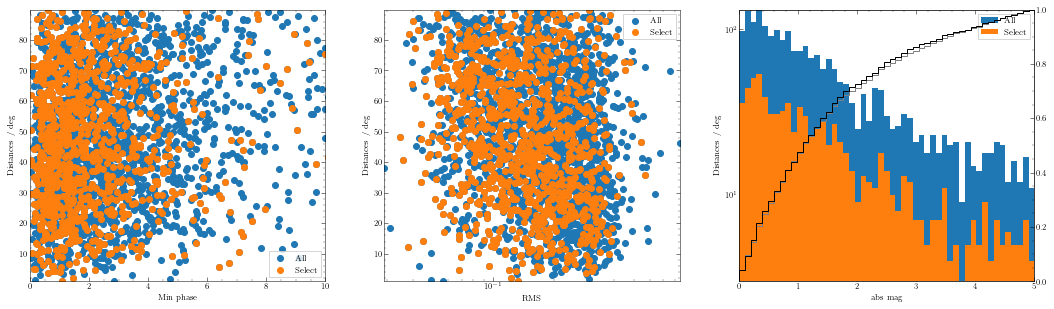

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

ax[0].scatter( data.loc[cond,'minphase'], data.loc[cond,'spins.distance'], label='All' )
ax[0].scatter( data.loc[maskFINK,'minphase'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[0].legend()
ax[0].set_xlabel('Min phase')
ax[0].set_ylabel('Distances / deg')
ax[0].set_xlim(0,10)


ax[1].scatter( data.loc[cond,'HG1G2hyb_rms'], data.loc[cond,'spins.distance'], label='All' )
ax[1].scatter( data.loc[maskFINK,'HG1G2hyb_rms'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[1].legend()
ax[1].set_xlabel('RMS')
ax[1].set_xscale('log')
ax[1].set_ylabel('Distances / deg')

r = [0,5]
b = 51
ax[2].hist( data.loc[cond,'spins.distance']/data.loc[cond,'HG1G2hyb_dSpin'], range=r, bins=b, label='All' )
ax[2].hist( data.loc[maskFINK,'spins.distance']/data.loc[maskFINK,'HG1G2hyb_dSpin'], range=r, bins=b, label='Select' )
ax2 = ax[2].twinx()
ax2.hist( data.loc[cond,'spins.distance']/data.loc[cond,'HG1G2hyb_dSpin'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='gray' )
ax2.hist( data.loc[maskFINK,'spins.distance']/data.loc[maskFINK,'HG1G2hyb_dSpin'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[2].set_xlim(r)

ax[2].legend()
ax[2].set_xlabel('abs mag')
ax[2].set_yscale('log')
ax[2].set_ylabel('Distances / deg')


In [46]:
data.columns[:80]

Index(['ssnamenr', 'number', 'name', 'minphase', 'maxphase', 'n_days', 'n_obs',
       'HG_H', 'HG_dH', 'HG_G', 'HG_dG', 'HG_rms', 'HG_chi2red', 'HG1G2_H',
       'HG1G2_dH', 'HG1G2_G1', 'HG1G2_dG1', 'HG1G2_G2', 'HG1G2_dG2',
       'HG1G2_rms', 'HG1G2_chi2red', 'HG1G2sp_H', 'HG1G2sp_dH', 'HG1G2sp_G1',
       'HG1G2sp_dG1', 'HG1G2sp_G2', 'HG1G2sp_dG2', 'HG1G2sp_RA0',
       'HG1G2sp_dRA0', 'HG1G2sp_DEC0', 'HG1G2sp_dDEC0', 'HG1G2sp_R',
       'HG1G2sp_dR', 'HG1G2sp_rms', 'HG1G2sp_chi2red', 'HG1G2hyb_H_g',
       'HG1G2hyb_dH_g', 'HG1G2hyb_G1_g', 'HG1G2hyb_dG1_g', 'HG1G2hyb_G2_g',
       'HG1G2hyb_dG2_g', 'HG1G2hyb_H_r', 'HG1G2hyb_dH_r', 'HG1G2hyb_G1_r',
       'HG1G2hyb_dG1_r', 'HG1G2hyb_G2_r', 'HG1G2hyb_dG2_r', 'HG1G2hyb_RA0',
       'HG1G2hyb_dRA0', 'HG1G2hyb_DEC0', 'HG1G2hyb_dDEC0', 'HG1G2hyb_R',
       'HG1G2hyb_dR', 'HG1G2hyb_rms', 'HG1G2hyb_chi2red', 'HG1G2hyb_n_oppo',
       'HG1G2hyb_status', 'HG1G2hyb_fit', 'HG1G2hyb_dSpin', 'lon', 'lat',
       'sso_number', 'sso_name', 'sso_cl

Text(0, 0.5, 'Distances / deg')

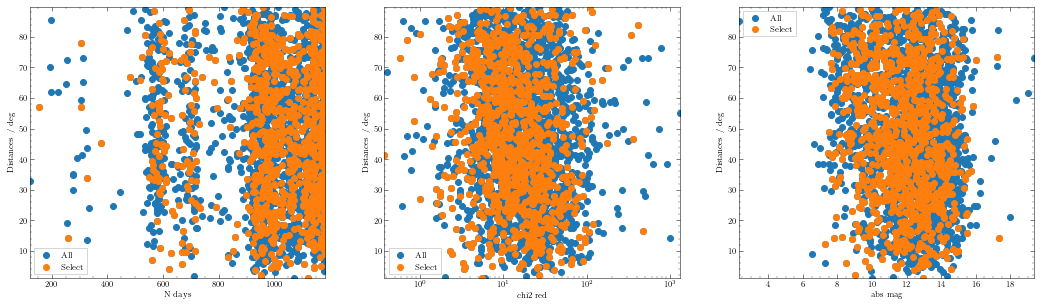

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

ax[0].scatter( data.loc[cond,'n_days'], data.loc[cond,'spins.distance'], label='All' )
ax[0].scatter( data.loc[maskFINK,'n_days'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[0].legend()
ax[0].set_xlabel('N days')
ax[0].set_ylabel('Distances / deg')

ax[1].scatter( data.loc[cond,'HG1G2hyb_chi2red'], data.loc[cond,'spins.distance'], label='All' )
ax[1].scatter( data.loc[maskFINK,'HG1G2hyb_chi2red'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[1].legend()
ax[1].set_xlabel('chi2 red')
ax[1].set_xscale('log')
ax[1].set_ylabel('Distances / deg')

ax[2].scatter( data.loc[cond,'absolute_magnitude.value'], data.loc[cond,'spins.distance'], label='All' )
ax[2].scatter( data.loc[maskFINK,'absolute_magnitude.value'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[2].legend()
ax[2].set_xlabel('abs mag')
# ax[2].set_xscale('log')
ax[2].set_ylabel('Distances / deg')


(40582, 2799)

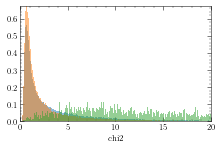

In [48]:
r = [0,20]
b = 200 
plt.hist(data['HG1G2hyb_chi2red'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK,'HG1G2hyb_chi2red'], range=r, bins=b, alpha=0.5, density=True )

cond = data['spins.1.RA0.value'].notna()
plt.hist(data.loc[cond,'HG1G2hyb_chi2red'], range=r, bins=b, alpha=0.5, density=True )
# plt.xlim(0,10)
plt.xlabel('chi2')

len(data[maskFINK]), len(data[cond])

- fishy: the object with spins have shitty chi2red!
- Explanation: there is bias for high amplitude for LC-derived spins -> bad for HG1G2hybrid (LC not taken into account)

(40582, 2799)

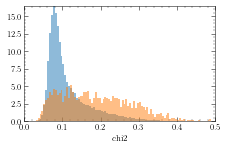

In [49]:
r = [0,0.5]
b = 100 
# plt.hist(data['HG1G2hyb_rms'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK,'HG1G2hyb_rms'], range=r, bins=b, alpha=0.5, density=True )

cond = data['spins.1.RA0.value'].notna()
plt.hist(data.loc[cond,'HG1G2hyb_rms'], range=r, bins=b, alpha=0.5, density=True )
# plt.xlim(0,10)
plt.xlabel('chi2')

len(data[maskFINK]), len(data[cond])

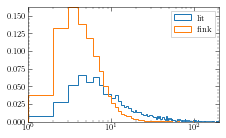

In [50]:
fig, ax = plt.subplots()

ax.hist( data.loc[cond,'diameter.value'], histtype='step', bins=np.linspace(1,200,num=200), density=True, label='lit')
ax.hist( data.loc[maskFINK,'diameter.value'], histtype='step', bins=np.linspace(1,200,num=200), density=True, label='fink' )

ax.set_xscale('log')
ax.legend()

In [51]:
cond = maskFINK
lim_spin = 30
spin_v = '1'
cond = cond * (data[f'spins.{spin_v}.distance'] < lim_spin)
data.loc[cond,f'spins.{spin_v}.technique'].value_counts()

# plt.hist( data.loc[cond,'spins.1.distance'] )

LCI       146
LC+TPM     31
LC         11
TE          3
LC-TPM      3
LC+Occ      2
ADAM        2
Radar       1
Name: spins.1.technique, dtype: int64

In [52]:
cond = maskFINK
cond = cond * (data[f'spins.{spin_v}.distance'] < lim_spin)
cond = cond * (data[f'spins.{spin_v}.technique']=='Radar')

cols = ['number','name', #'minphase','maxphase','n_days',
        'HG1G2hyb_RA0','HG1G2hyb_DEC0',
        'spins.1.RA0.value','spins.1.DEC0.value', 'spins.1.version',
        'spins.2.RA0.value','spins.2.DEC0.value', 'spins.2.version',
        'spins.1.distance', 'spins.2.distance']
data.loc[cond,cols].sort_values(by='number')
# data.loc[cond,'spins.1.technique'].value_counts()

,number,name,HG1G2hyb_RA0,HG1G2hyb_DEC0,spins.1.RA0.value,spins.1.DEC0.value,spins.1.version,spins.2.RA0.value,spins.2.DEC0.value,spins.2.version,spins.1.distance,spins.2.distance
28243,3908,Nyx,102.337435,-68.389817,324.095112,72.90479,B,NaN,NaN,NaN,14.211839,NaN


In [53]:
cond = maskFINK
data[cond].sort_values(by='sso_number').head(20)

,ssnamenr,number,name,minphase,maxphase,n_days,n_obs,HG_H,HG_dH,HG_G,...,spins.4.delta_RA.B,spins.4.delta_DEC.B,spins.4.closest,spins.4.version,spins.4.delta_RA,spins.4.delta_DEC,spins.closest,spins.distance,spins.delta_RA,spins.delta_DEC
99158,24,24,Themis,1.037637,19.738912,1125.539445,82,6.978320,0.070092,9.613605e-17,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,12.370779,-12.690628,-4.825571
9294,33,33,Polyhymnia,3.812072,25.814893,1158.398438,199,8.664804,0.028526,3.374419e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,1,47.897441,55.821262,-14.852113
9711,36,36,Atalante,1.852573,30.526404,572.050660,87,8.308298,0.067166,9.645466e-04,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,42.601555,-50.371451,9.579626
75079,38,38,Leda,0.675514,22.034192,1163.636458,97,8.613089,0.055079,2.502589e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,65.733707,63.318258,16.171087
33816,41,41,Daphne,4.146747,29.255384,1098.796991,106,7.262022,0.088789,3.899752e-11,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,42.005188,-247.623195,-6.155299
83193,45,45,Eugenia,3.468731,21.845050,1172.407847,146,7.711499,0.158616,2.401015e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,63.389553,65.592287,-28.033549
8121,46,46,Hestia,0.681605,29.102391,1178.660880,131,8.544425,0.129448,1.317698e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,1,80.477264,-48.701192,70.918190
1028,49,49,Pales,9.336479,23.835736,946.957859,174,8.301038,0.120403,5.479326e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
65784,53,53,Kalypso,0.948405,28.342319,998.970671,126,8.805468,0.059812,9.401087e-18,...,NaN,NaN,<NA>,NaN,NaN,NaN,1,77.330021,74.391229,44.401585
84579,58,58,Concordia,1.171909,22.695131,1138.565023,137,8.800727,0.046967,7.480369e-03,...,NaN,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,NaN,NaN


In [54]:
cond = maskFINK
cols = ['number','name', #'minphase','maxphase','n_days',
        'HG1G2hyb_RA0','HG1G2hyb_DEC0',
        'spins.1.RA0.value','spins.1.DEC0.value', 'spins.1.version',
        'spins.2.RA0.value','spins.2.DEC0.value', 'spins.2.version',
        'spins.1.distance', 'spins.2.distance']
data.loc[cond,cols].sort_values(by='number').head(20)

,number,name,HG1G2hyb_RA0,HG1G2hyb_DEC0,spins.1.RA0.value,spins.1.DEC0.value,spins.1.version,spins.2.RA0.value,spins.2.DEC0.value,spins.2.version,spins.1.distance,spins.2.distance
99158,24,Themis,275.627081,69.338571,246.135000,64.513000,A,NaN,NaN,NaN,12.370779,NaN
9294,33,Polyhymnia,136.867775,58.062113,157.258000,-49.633000,B,33.456,-43.210,B,71.008973,47.897441
9711,36,Atalante,239.820509,-61.875626,157.458000,-52.296000,A,57.416,-30.524,A,42.601555,87.579871
75079,38,Leda,271.207851,-8.231087,155.139000,-7.940000,B,346.679,-12.214,A,65.733707,74.160006
33816,41,Daphne,307.116022,42.040299,181.482000,-35.885000,B,NaN,NaN,NaN,42.005188,NaN
83193,45,Eugenia,232.798255,44.048549,121.039000,-16.015000,B,NaN,NaN,NaN,63.389553,NaN
8121,46,Hestia,160.000514,-61.975190,112.808000,28.869000,B,290.700,-8.943,B,81.570520,80.477264
1028,49,Pales,304.754238,69.988341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65784,53,Kalypso,92.265930,-47.412585,173.803000,15.763000,B,346.760,3.011,B,84.021156,77.330021
84579,58,Concordia,110.820762,56.733686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
data.columns[:80]

Index(['ssnamenr', 'number', 'name', 'minphase', 'maxphase', 'n_days', 'n_obs',
       'HG_H', 'HG_dH', 'HG_G', 'HG_dG', 'HG_rms', 'HG_chi2red', 'HG1G2_H',
       'HG1G2_dH', 'HG1G2_G1', 'HG1G2_dG1', 'HG1G2_G2', 'HG1G2_dG2',
       'HG1G2_rms', 'HG1G2_chi2red', 'HG1G2sp_H', 'HG1G2sp_dH', 'HG1G2sp_G1',
       'HG1G2sp_dG1', 'HG1G2sp_G2', 'HG1G2sp_dG2', 'HG1G2sp_RA0',
       'HG1G2sp_dRA0', 'HG1G2sp_DEC0', 'HG1G2sp_dDEC0', 'HG1G2sp_R',
       'HG1G2sp_dR', 'HG1G2sp_rms', 'HG1G2sp_chi2red', 'HG1G2hyb_H_g',
       'HG1G2hyb_dH_g', 'HG1G2hyb_G1_g', 'HG1G2hyb_dG1_g', 'HG1G2hyb_G2_g',
       'HG1G2hyb_dG2_g', 'HG1G2hyb_H_r', 'HG1G2hyb_dH_r', 'HG1G2hyb_G1_r',
       'HG1G2hyb_dG1_r', 'HG1G2hyb_G2_r', 'HG1G2hyb_dG2_r', 'HG1G2hyb_RA0',
       'HG1G2hyb_dRA0', 'HG1G2hyb_DEC0', 'HG1G2hyb_dDEC0', 'HG1G2hyb_R',
       'HG1G2hyb_dR', 'HG1G2hyb_rms', 'HG1G2hyb_chi2red', 'HG1G2hyb_n_oppo',
       'HG1G2hyb_status', 'HG1G2hyb_fit', 'HG1G2hyb_dSpin', 'lon', 'lat',
       'sso_number', 'sso_name', 'sso_cl

# Obliquity

In [56]:
# Obliquity of the spin
data['lon_orbit'] = data['orbital_elements.node_longitude.value'] - 90
data['lat_orbit'] = 90. - data['orbital_elements.inclination.value']
data['obliquity'] = data[['lon','lat', 'lon_orbit','lat_orbit']].apply(
    lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
)


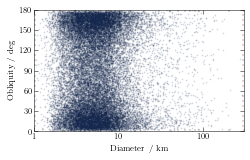

In [57]:
fig, ax = plt.subplots(figsize=fs.figsize(0.5), 
                      gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

cond = data.ssnamenr==data.ssnamenr
cond = maskFINK
ax.scatter( data.loc[cond,'diameter.value'],
            data.loc[cond,'obliquity'], 
            marker='.',
            color=colors[0], 
            s=2, 
            alpha=0.15 )

ax.set_xscale('log')
ax.set_xlim(1,300)
ax.set_ylim(0,180)
ax.set_xlabel('Diameter / km')
ax.set_ylabel('Obliquity / deg')


ax.set_xticks([1,10,100])
ax.set_xticklabels(['1','10','100'])
ax.set_yticks([0,30,60,90,120,150,180])

fig.savefig(f'{data_fink}plots/obliquity_vs_diameter.png', facecolor='white', dpi=150)


(array([ 469., 1122., 1065., 1034.,  996.,  826.,  660.,  624.,  544.,
         497.,  419.,  443.,  392.,  365.,  379.,  340.,  347.,  336.,
         329.,  365.,  315.,  352.,  379.,  343.,  344.,  429.,  424.,
         489.,  571.,  614.,  688.,  822.,  945., 1100., 1041., 1044.,
         439.]),
 array([  0.        ,   4.86486486,   9.72972973,  14.59459459,
         19.45945946,  24.32432432,  29.18918919,  34.05405405,
         38.91891892,  43.78378378,  48.64864865,  53.51351351,
         58.37837838,  63.24324324,  68.10810811,  72.97297297,
         77.83783784,  82.7027027 ,  87.56756757,  92.43243243,
         97.2972973 , 102.16216216, 107.02702703, 111.89189189,
        116.75675676, 121.62162162, 126.48648649, 131.35135135,
        136.21621622, 141.08108108, 145.94594595, 150.81081081,
        155.67567568, 160.54054054, 165.40540541, 170.27027027,
        175.13513514, 180.        ]),
 <BarContainer object of 37 artists>)

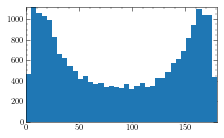

In [58]:
cond = maskFINK & (data['diameter.value']<10)
fig, ax = plt.subplots()

r = [0,180]
b = 37
ax.hist( data.loc[cond,'obliquity'], bins=b, range=r )

# Oblateness

In [59]:
damit = pd.read_csv( f'{data_fink}/data/damit.csv' )

In [65]:
np.mean(damit.R), np.mean(damit.R2)

(0.6131972585404981, 0.7431183878107439)

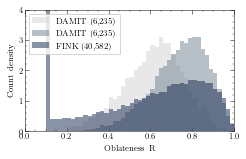

In [64]:
fig, ax = plt.subplots(figsize=fs.figsize(0.5), 
                      gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

r = [0,1]
b = 50

colors = ['#15284F', '#F5622E']


ax.hist( damit.R, range=r, bins=b, 
        color='lightgray', 
        density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )

ax.hist( damit.R2, range=r, bins=b, 
        color='slategray', 
        density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )
# ax.hist( data.loc[maskFINK,'HG1G2hyb_R'], range=r, bins=b, density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

cond = (data.HG1G2hyb_dR<0.9) & maskFINK
ax.hist( data.loc[cond,'HG1G2hyb_R'], range=r, bins=b, 
         color=colors[0], 
        density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

ax.set_ylim(0,4)
ax.set_xlabel('Oblateness R')
ax.set_ylabel('Count density')
ax.legend(loc='upper left')

fig.savefig(f'{data_fink}plots/R_and_damit.png', facecolor='white', dpi=150)


In [36]:
# damit.sort_values(by='R').head(40)
cond = maskFINK & (data.HG1G2hyb_R>0.18)
data[cond].sort_values(by='HG1G2hyb_R').head(40)

,ssnamenr,number,name,minphase,maxphase,n_days,n_obs,HG_H,HG_dH,HG_G,...,spins.4.version,spins.4.delta_RA,spins.4.delta_DEC,spins.closest,spins.distance,spins.delta_RA,spins.delta_DEC,lon_orbit,lat_orbit,obliquity
89217,7412,7412,Linnaeus,0.289574,19.475603,949.949873,169,13.093161,0.036314,9.006944e-02,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,9.174558,87.426405,3.761537
20061,10333,10333,Portnoff,1.595698,22.700077,1007.995984,133,13.492100,0.047319,3.550634e-01,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,27.652230,85.604830,22.078404
14112,178696,178696,2000 SB58,0.825724,19.903504,602.784965,55,14.968555,0.038764,9.711355e-02,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,80.363584,80.221896,42.518027
68506,27337,27337,2000 CR90,1.206443,25.000178,507.961458,56,15.741553,0.058816,3.298380e-01,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,92.037740,78.850804,137.413020
48657,91676,91676,1999 TM115,2.770123,20.715257,533.857164,54,14.915300,0.039955,2.693064e-19,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,121.136640,79.165959,161.072055
100291,36666,36666,2000 QA212,0.069681,21.151219,948.057928,56,15.404400,0.043843,1.037851e-13,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,254.531115,87.264048,139.823629
64064,25233,25233,Tallman,1.802103,20.824451,996.854271,143,13.762201,0.049723,5.778620e-02,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,105.381622,79.942609,150.376043
57245,54825,54825,2001 NE7,2.942434,19.100556,947.957083,72,14.310625,0.075192,8.162011e-03,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,227.145911,81.173760,149.365478
5962,24765,24765,1993 FE8,1.109784,28.890297,1069.921898,110,14.838893,0.055248,4.013143e-02,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,-5.046771,85.793146,4.109708
44637,46470,46470,9607 P-L,2.511256,20.694951,964.094398,146,13.906075,0.035452,1.872050e-01,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,-86.095384,80.402737,5.927706


Text(0, 0.5, 'R')

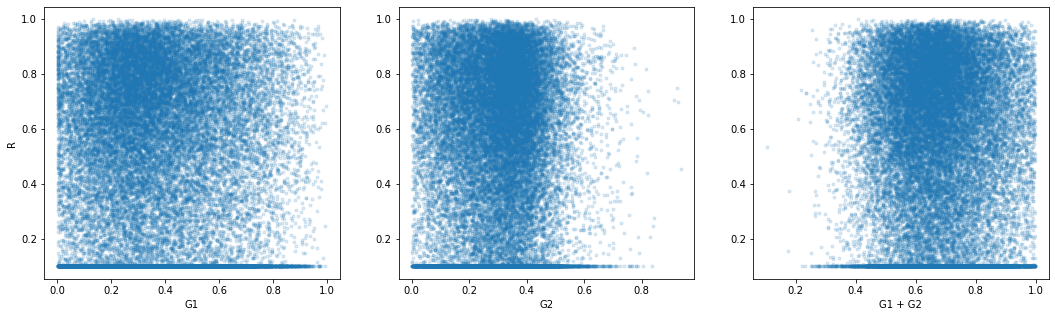

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

r = [0,1]
b = 50


cond = maskFINK

ax[0].scatter( data.loc[cond,'HG1G2hyb_G1_r'], data.loc[cond,'HG1G2hyb_R'], marker='.', alpha=0.15 )
ax[1].scatter( data.loc[cond,'HG1G2hyb_G2_r'], data.loc[cond,'HG1G2hyb_R'], marker='.', alpha=0.15 )
ax[2].scatter( data.loc[cond,'HG1G2hyb_G1_r']+data.loc[cond,'HG1G2hyb_G2_r'], data.loc[cond,'HG1G2hyb_R'], marker='.', alpha=0.15 )

ax[0].set_xlabel('G1')
ax[1].set_xlabel('G2')
ax[2].set_xlabel('G1 + G2')
ax[0].set_ylabel('R')

# ax.legend(loc='upper left')

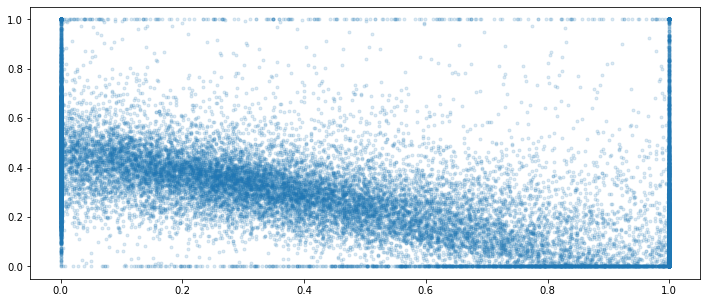

In [38]:
fig, ax = plt.subplots(figsize=(12,5))

r = [0,1]
b = 50

cond = data['HG1G2hyb_R']<0.2

ax.scatter( data.loc[cond,'HG1G2hyb_G1_r'], data.loc[cond,'HG1G2hyb_G2_r'], marker='.', alpha=0.15 )

# ax[0].set_xlabel('G1')
# ax[1].set_xlabel('G2')
# ax[2].set_xlabel('G1 + G2')
# ax[0].set_ylabel('R')

# ax.legend(loc='upper left')